In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib # Để lưu scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Cấu hình
pd.set_option('display.max_columns', None)
TIME_STEPS = 14  # Dùng 14 ngày quá khứ
TARGET_COLS = ['MaxTemp', 'Humidity3pm', 'WindGustSpeed'] # 3 Mục tiêu dự báo

In [3]:
# PHẦN 1: XỬ LÝ DỮ LIỆU (FULL DATASET)
# ==========================================
print("--- [1/5] Đang tải và xử lý dữ liệu... ---")

# 1. Load Data
df = pd.read_csv('weatherAUS.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Loại bỏ các dòng mà TARGET bị thiếu (vì ta cần nhãn để train)
df.dropna(subset=TARGET_COLS, inplace=True)

# 2. Chọn Features (Đầu vào)
# Lưu ý: Ta dùng chính các biến mục tiêu làm đầu vào luôn (quá khứ dự báo tương lai)
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
            'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

# Lọc dữ liệu
data_subset = df[features + ['Location', 'Date']].copy()

# 3. Điền dữ liệu thiếu (Imputation)
imputer = SimpleImputer(strategy='mean')
# Chỉ lấy các cột số (features) để điền
data_subset[features] = imputer.fit_transform(data_subset[features])

# 4. Scaling (Chuẩn hóa về 0-1)
# Quan trọng: Ta cần scaler riêng cho Output để sau này inverse_transform lại số thực
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale Input
feature_data_scaled = scaler_input.fit_transform(data_subset[features].values)

# Scale Output (Target) riêng biệt
target_data_scaled = scaler_target.fit_transform(data_subset[TARGET_COLS].values)

# Gán ngược lại vào DataFrame để chuẩn bị cắt chuỗi
df_processed = pd.DataFrame(feature_data_scaled, columns=features)
# Thêm các cột target đã scale vào (đặt tên tạm để dùng)
for i, col in enumerate(TARGET_COLS):
    df_processed[f'TARGET_{col}'] = target_data_scaled[:, i]

df_processed['Location'] = data_subset['Location'].values
df_processed['Date'] = data_subset['Date'].values

--- [1/5] Đang tải và xử lý dữ liệu... ---


In [4]:
# ==========================================
# PHẦN 2: TẠO CHUỖI THỜI GIAN (STACKING SEQUENCES)
# ==========================================
print("--- [2/5] Đang tạo Sliding Window... ---")

def create_dataset_regression(dataset, time_steps=14):
    X_list, y_list = [], []

    grouped = dataset.groupby('Location')

    for name, group in grouped:
        group = group.sort_values('Date')

        # Lấy data inputs (features)
        data_values = group[features].values

        # Lấy data targets (3 cột mục tiêu)
        target_col_names = [f'TARGET_{c}' for c in TARGET_COLS]
        target_values = group[target_col_names].values

        for i in range(len(data_values) - time_steps):
            X_list.append(data_values[i:(i + time_steps)])
            # Output là giá trị của ngày tiếp theo (i + time_steps)
            y_list.append(target_values[i + time_steps])

    return np.array(X_list), np.array(y_list)

X, y = create_dataset_regression(df_processed, TIME_STEPS)
print(f"Kích thước dữ liệu: Input {X.shape}, Output {y.shape}")

# Chia Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

--- [2/5] Đang tạo Sliding Window... ---
Kích thước dữ liệu: Input (132100, 14, 12), Output (132100, 3)


In [5]:
# ==========================================
# PHẦN 3: XÂY DỰNG MODEL LSTM (REGRESSION)
# ==========================================
print("\n--- [3/5] Training Regression Model (LSTM)... ---")

model_reg = Sequential()

# Layer 1: LSTM
model_reg.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_reg.add(Dropout(0.2))

# Layer 2: LSTM
model_reg.add(LSTM(32, return_sequences=False))
model_reg.add(Dropout(0.2))

# Layer 3: Dense Output
# Output layer có số nơ-ron bằng số lượng biến cần dự báo (3 biến)
# Activation='linear' (mặc định) vì đây là bài toán hồi quy
model_reg.add(Dense(len(TARGET_COLS)))

# Compile: Dùng MSE làm hàm mất mát, MAE để đánh giá
optimizer = Adam(learning_rate=0.001)
model_reg.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train
history = model_reg.fit(
    X_train, y_train,
    epochs=20, # Tăng lên 30-50 nếu cần
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


--- [3/5] Training Regression Model (LSTM)... ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0240 - mae: 0.1105 - val_loss: 0.0122 - val_mae: 0.0784
Epoch 2/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0130 - mae: 0.0833 - val_loss: 0.0113 - val_mae: 0.0750
Epoch 3/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0120 - mae: 0.0788 - val_loss: 0.0110 - val_mae: 0.0750
Epoch 4/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0116 - mae: 0.0769 - val_loss: 0.0108 - val_mae: 0.0736
Epoch 5/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0113 - mae: 0.0759 - val_loss: 0.0108 - val_mae: 0.0732
Epoch 6/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0112 - mae: 0.0754 - val_loss: 0.0108 - val_mae: 0.0720
Epoch 7/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0111 - mae: 0.0749 - val_loss: 0.0106 - val_mae: 0.0719
Epoch 8/20
1487/1487 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0110 - mae: 0.0745 - val_loss: 0.0106 - val_mae: 0.0712
Epoch 9/20
1487/1487 ━━━


--- [4/5] Đánh giá sai số... ---
826/826 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

KẾT QUẢ SAI SỐ TRUNG BÌNH (MAE):
- MaxTemp: Sai lệch khoảng 2.05
- Humidity3pm: Sai lệch khoảng 10.73
- WindGustSpeed: Sai lệch khoảng 8.54


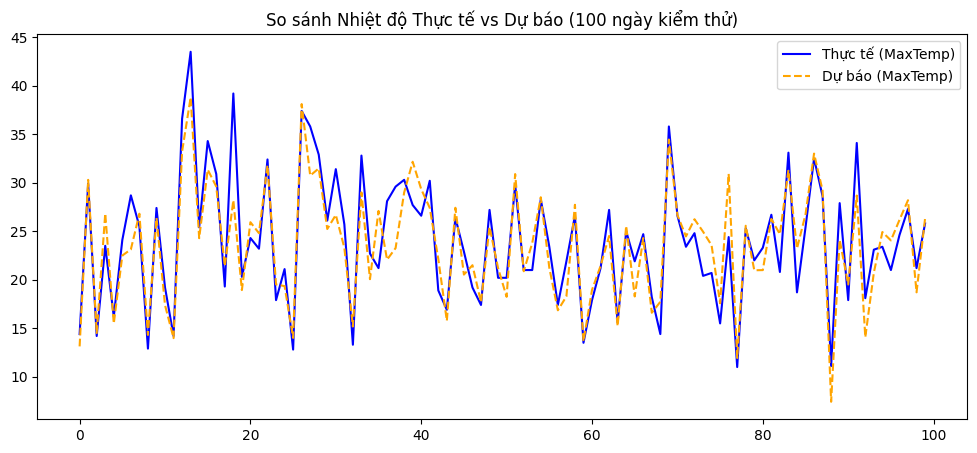

In [6]:
# ==========================================
# PHẦN 4: ĐÁNH GIÁ MODEL
# ==========================================
print("\n--- [4/5] Đánh giá sai số... ---")

# Dự báo trên tập test
y_pred_scaled = model_reg.predict(X_test)

# Quan trọng: Scale ngược trở lại đơn vị gốc (độ C, %, km/h)
y_pred_original = scaler_target.inverse_transform(y_pred_scaled)
y_test_original = scaler_target.inverse_transform(y_test)

# Tính sai số trung bình (MAE) cho từng chỉ số
print("\nKẾT QUẢ SAI SỐ TRUNG BÌNH (MAE):")
for i, col in enumerate(TARGET_COLS):
    mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
    print(f"- {col}: Sai lệch khoảng {mae:.2f}")
    # Ví dụ: MaxTemp sai lệch khoảng 2.5 độ

# Vẽ biểu đồ so sánh cho 100 mẫu đầu tiên (MaxTemp)
plt.figure(figsize=(12, 5))
plt.plot(y_test_original[:100, 0], label='Thực tế (MaxTemp)', color='blue')
plt.plot(y_pred_original[:100, 0], label='Dự báo (MaxTemp)', color='orange', linestyle='--')
plt.title('So sánh Nhiệt độ Thực tế vs Dự báo (100 ngày kiểm thử)')
plt.legend()
plt.show()